# --> Importations

To start this notebook you need to download the following files.

- full_numpy_bitmap_airplane.npy
- full_numpy_bitmap_book.npy
- full_numpy_bitmap_car.npy
- full_numpy_bitmap_dog.npy
- full_numpy_bitmap_face.npy
- full_numpy_bitmap_apple.npy
- full_numpy_bitmap_brain.npy
- full_numpy_bitmap_chair.npy
- full_numpy_bitmap_eye.npy
- full_numpy_bitmap_The Eiffel Tower.npy

Then you need to store the file at the root in ./Datasets/QuickDraw.<br>

Link : https://console.cloud.google.com/storage/browser/quickdraw_dataset/full/numpy_bitmap/?pli=1

In [42]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# --> Import QuickDraw dataset

In [43]:
dataset_dir = "../../Datasets/QuickDraw/"
files = os.listdir(dataset_dir)
max_size_per_cl = 1500 #maximum d'image par type d'image dans le dataset
draw_class = []
size = 0

#Evaluation de la taille du dataset
for name in files:
    draws = np.load(os.path.join(dataset_dir, name))
    draws = draws[:max_size_per_cl]
    size += draws.shape[0]
    
#Buffer permettant de stocker les images et les targets
images = np.zeros((size, 28, 28))
targets = np.zeros((size, ))

#Itere dans la dataset et ajoute a la liste draw_class
it = 0
t = 0
for name in files:
    #Ouvre chaque dataset et creer une nouvelle classe avec un nom
    draw_class.append(name.replace("full_numpy_bitmap_", "").replace(".npy", ""))
    draws = np.load(os.path.join(dataset_dir, name))
    draws = draws[:max_size_per_cl]
    #Ajoute les images au buffers
    images[it:it+draws.shape[0]] = np.invert(draws.reshape(-1, 28, 28))
    targets[it:it+draws.shape[0]] = t
    #Itere sur chaque dataset
    it += draws.shape[0]
    t += 1
    
#Shuffle randomly
indexes = np.arange(size)
np.random.shuffle(indexes)
images = images[indexes]
targets = targets[indexes]

#Affichage de notre train set et validation set
images, images_valid, targets, targets_valid = train_test_split(images, targets, test_size=0.33)
print("Shape images : ", images.shape)
print("Shape targets : ", targets.shape)
print("\nShape valid images : ", images_valid.shape)
print("Shape valid targets : ", targets_valid.shape)
print("\nClasses possibles : ", draw_class)

Shape images :  (10050, 28, 28)
Shape targets :  (10050,)

Shape valid images :  (4950, 28, 28)
Shape valid targets :  (4950,)

Classes possibles :  ['airplane', 'apple', 'book', 'brain', 'car', 'chair', 'dog', 'eye', 'face', 'The Eiffel Tower']


# --> Exemple d'image affiche

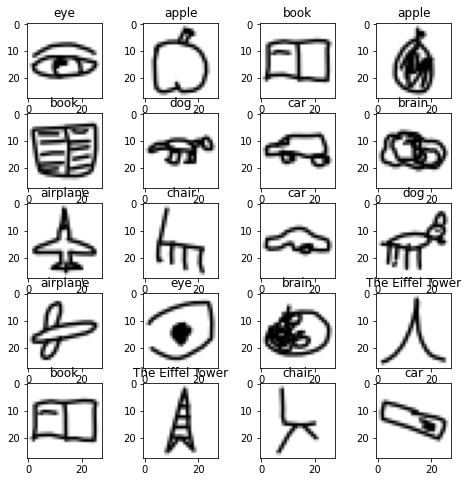

In [44]:
w = 10
h = 10
fig = plt.figure(figsize=(8, 8))
columns = 4
rows = 5
for i in range(1, columns*rows+1):
    index = np.random.randint(len(images))     #Index d'une image aleatoire
    img = images[index]                        #On recupere cette image
    fig.add_subplot(rows, columns, i)          #Ajout d'un nouveau graph 4*5
    plt.title(draw_class[int(targets[index])]) #Ajout d'un titre par plot
    plt.imshow(img, cmap="gray")               #Affichage de l'image en noir et blanc
plt.show()

# --> Normalization

In [48]:
print("Moyenne et ecart type du dataset : ", images.mean(), images.std())
scaler = StandardScaler()
scaled_images = scaler.fit_transform(images.reshape(-1, 28*28))
scaled_images_valid = scaler.transform(images_valid.reshape(-1, 28*28))
print("Moyenne et ecart type du dataset apres normalisation : ", scaled_images.mean(), scaled_images.std())

scaled_images = scaled_images.reshape(-1, 28, 28, 1)
scaled_images_valid = scaled_images_valid.reshape(-1, 28, 28, 1)

Moyenne et ecart type du dataset :  209.41387044369986 85.26672896117638
Moyenne et ecart type du dataset apres normalisation :  -1.1528554084116562e-16 0.9285714285714304


# --> Utilisation de tf.data

In [49]:
train_dataset = tf.data.Dataset.from_tensor_slices(scaled_images) #Permet de split en batch apres
valid_dataset = tf.data.Dataset.from_tensor_slices(scaled_images_valid)

#(10050, 28, 28, 1)
#10050 images, 28 par 28, 1 : niveau de gris
print("Shape of scaled_image : ", scaled_images.shape)

for item in train_dataset:
    print("Shape of train dataset items : ", item.shape)
    break

Shape of scaled_image :  (10050, 28, 28, 1)
Shape of train dataset items :  (28, 28, 1)


In [64]:
#Si on train le reseau sur tous le dataset, ici 10050 images on va avoir un probleme
#car il va falloir calculer le gradient avec enormement de data. Il faut donc separer
#nos data en plusieurs batch de differentes tailles.
epoch = 1 #1 epoch : ensemble des batch du dataset
batch_size = 1000
print("Batchs shape :")
for batch_training in train_dataset.repeat(epoch).batch(batch_size): #Repeat = nbr d'epoch
    #(1000, 28, 28, 1)
    #1000 : tailles du batch actuel pour le train, 28 par 28, 1 : niveau de gris
    print(batch_training.shape)

Batchs shape :
(1000, 28, 28, 1)
(1000, 28, 28, 1)
(1000, 28, 28, 1)
(1000, 28, 28, 1)
(1000, 28, 28, 1)
(1000, 28, 28, 1)
(1000, 28, 28, 1)
(1000, 28, 28, 1)
(1000, 28, 28, 1)
(1000, 28, 28, 1)
(50, 28, 28, 1)


# --> Creation du dataset complet

In [69]:
train_dataset = tf.data.Dataset.from_tensor_slices((scaled_images, targets))
valid_dataset = tf.data.Dataset.from_tensor_slices((scaled_images_valid, targets_valid))
epoch = 1
batch_size = 1000
for images_batch, targets_batch in train_dataset.repeat(epoch).batch(batch_size):
    print("Batch shape : ", images_batch.shape, targets_batch.shape)

Batch shape :  (1000, 28, 28, 1) (1000,)
Batch shape :  (1000, 28, 28, 1) (1000,)
Batch shape :  (1000, 28, 28, 1) (1000,)
Batch shape :  (1000, 28, 28, 1) (1000,)
Batch shape :  (1000, 28, 28, 1) (1000,)
Batch shape :  (1000, 28, 28, 1) (1000,)
Batch shape :  (1000, 28, 28, 1) (1000,)
Batch shape :  (1000, 28, 28, 1) (1000,)
Batch shape :  (1000, 28, 28, 1) (1000,)
Batch shape :  (1000, 28, 28, 1) (1000,)
Batch shape :  (50, 28, 28, 1) (50,)


# --> On build notre model CNN grace a subclassing

In [70]:
class CNN(tf.keras.Model):
    
    def __init__(self):
        super(CNN, self).__init__()
        #Convolutions
        self.conv1 = tf.keras.layers.Conv2D(32, 4, activation="relu", name="conv1")
        self.conv1 = tf.keras.layers.Conv2D(64, 3, activation="relu", name="conv2")
        self.conv1 = tf.keras.layers.Conv2D(128, 3, activation="relu", name="conv3")
        #Flatten convolutions
        self.flatten = tf.keras.layers.Flatten(name="flatten")
        #Dense layers
        self.dense1 = tf.keras.layers.Dense(128, activation="relu", name="dense1")
        self.output_layer = tf.keras.layers.Dense(128, activation="softmax", name="output_layer")
        
    def build(self):
        
    def call(self):
    


IndentationError: expected an indented block (<ipython-input-70-559af12db303>, line 17)